In [1]:
!pip install gym==0.17.3
!pip install matplotlib
!pip install tensorflow==2.10

In [2]:
import random
import gym
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam




In [3]:

#the parameters like gamma, epsilon, epsilon_min, epsilon_decay, learning_rate, alpha, etc. are they all correct?

#baseline agent

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)
        
        self.gamma = 0.99           # Discount factor -----------------ASK CHER
        self.epsilon = 1.0          # Exploration rate 
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(12, input_dim=self.state_size, activation='relu'))
        model.add(Dense(12, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))  # Q-values for each discrete action
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state[np.newaxis, :], verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
    
        states = np.zeros((batch_size, self.state_size))
        targets = np.zeros((batch_size, self.action_size))
    
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state[np.newaxis, :], verbose=0)[0])
            target_f = self.model.predict(state[np.newaxis, :], verbose=0)[0]
            target_f[action] = target
    
            states[i] = state
            targets[i] = target_f
    
        
        self.GTfit(states, targets)
    
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def GTfit(self, X, Y):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        Y = tf.convert_to_tensor(Y, dtype=tf.float32)

        with tf.GradientTape() as tape:
            predictions = self.model(X, training=True)
            loss = tf.reduce_mean(tf.square(Y - predictions))  # MSE loss

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))


In [5]:
def train(agent, env , action_bins, episodes=500, batch_size=64):
    reward_history = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0

        for time in range(200):
            action_idx = agent.act(state)
            action = [action_bins[action_idx]]  # env expects an array

            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action_idx, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

        reward_history.append(total_reward)

        # 📊 Cumulative average (all episodes so far)
        cumulative_avg = sum(reward_history) / len(reward_history)

        # 📈 Moving average (last 5 episodes)
        if len(reward_history) >= 5:
            moving_avg = sum(reward_history[-5:]) / 5
        else:
            moving_avg = cumulative_avg  # use current average if < 5 episodes

        print(f"Episode {e+1}: Reward = {total_reward:.2f}, "
              f"Avg = {cumulative_avg:.2f}, "
              f"Moving Avg (last 5) = {moving_avg:.2f}")


        if len(reward_history) >= 5:
            avg_reward = sum(reward_history[-5:]) / 5
            if avg_reward >= -200:
                print(f"✅ Stopping early: 5-ep avg reward = {avg_reward:.2f} at episode {e+1}")
                break

    return reward_history


In [6]:
env = gym.make('Pendulum-v0')  # gym 0.17.3
state_size = env.observation_space.shape[0]

NUM_ACTIONS = 3 
action_bins = np.linspace(-2, 2, NUM_ACTIONS) 
print(action_bins)
action_size = NUM_ACTIONS  # number of discrete actions

agent = DQNAgent(state_size, action_size)

reward_history=train(agent, env, action_bins, episodes=100, batch_size=64)



[-2.  0.  2.]
Episode 1: Reward = -967.25, Avg = -967.25, Moving Avg (last 5) = -967.25
Episode 2: Reward = -1660.06, Avg = -1313.66, Moving Avg (last 5) = -1313.66
Episode 3: Reward = -1519.78, Avg = -1382.36, Moving Avg (last 5) = -1382.36
Episode 4: Reward = -1537.57, Avg = -1421.16, Moving Avg (last 5) = -1421.16
Episode 5: Reward = -1077.78, Avg = -1352.49, Moving Avg (last 5) = -1352.49
Episode 6: Reward = -949.03, Avg = -1285.24, Moving Avg (last 5) = -1348.84
Episode 7: Reward = -1405.10, Avg = -1302.37, Moving Avg (last 5) = -1297.85
Episode 8: Reward = -1224.03, Avg = -1292.57, Moving Avg (last 5) = -1238.70
Episode 9: Reward = -1160.58, Avg = -1277.91, Moving Avg (last 5) = -1163.30
Episode 10: Reward = -1175.23, Avg = -1267.64, Moving Avg (last 5) = -1182.79
Episode 11: Reward = -1073.60, Avg = -1250.00, Moving Avg (last 5) = -1207.71
Episode 12: Reward = -1216.88, Avg = -1247.24, Moving Avg (last 5) = -1170.06
Episode 13: Reward = -1407.93, Avg = -1259.60, Moving Avg (last

In [7]:

import matplotlib.pyplot as plt
import numpy as np

def plot_rewards(reward_history, moving_avg_window=10, target_reward=-200, title='DQN Training Performance'):
    plt.figure(figsize=(12, 6))

    # Plot raw episode rewards
    plt.plot(reward_history, label='Episode Reward')

    # Plot moving average
    if len(reward_history) >= moving_avg_window:
        moving_avg = np.convolve(reward_history, np.ones(moving_avg_window)/moving_avg_window, mode='valid')
        plt.plot(range(moving_avg_window - 1, len(reward_history)), moving_avg, label=f'Moving Avg ({moving_avg_window})')

    # Target line
    plt.axhline(y=target_reward, color='r', linestyle='--', label=f'Target Reward ({target_reward})')

    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


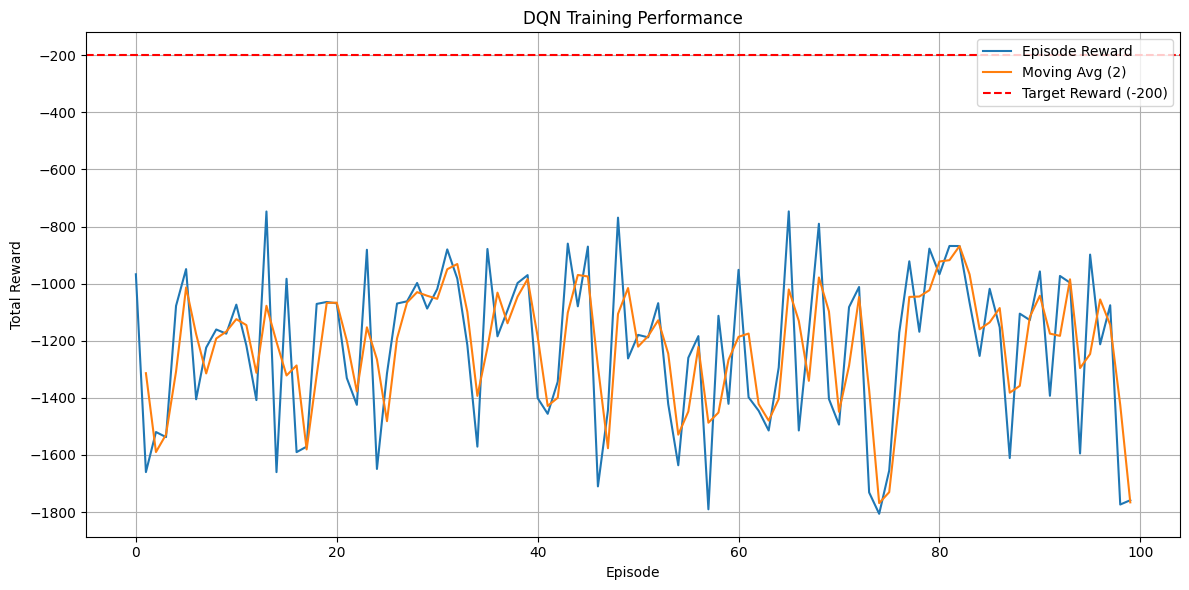

In [8]:
plot_rewards(reward_history, moving_avg_window=2)


#improved agent- btr hyperparams and target

In [9]:
class improvedDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)

        # Hyperparameters
        self.gamma = 0.99                # discount factor
        self.epsilon = 1.0               # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.985
        self.learning_rate = 0.0005
        self.target_update_freq = 10     # update target model every N episodes
        self.train_counter = 0

        # Build models
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state[np.newaxis], verbose=0)[0]
        return np.argmax(q_values)

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        states = np.zeros((batch_size, self.state_size))
        targets = np.zeros((batch_size, self.action_size))

        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            states[i] = state
            target = self.model.predict(state[np.newaxis], verbose=0)[0]
            if done:
                target[action] = reward
            else:
                next_qs = self.target_model.predict(next_state[np.newaxis], verbose=0)[0]
                target[action] = reward + self.gamma * np.amax(next_qs)
            targets[i] = target

        # Use GradientTape to apply custom training step
        states_tf = tf.convert_to_tensor(states, dtype=tf.float32)
        targets_tf = tf.convert_to_tensor(targets, dtype=tf.float32)

        with tf.GradientTape() as tape:
            predictions = self.model(states_tf, training=True)
            loss = tf.keras.losses.MSE(targets_tf, predictions)

        gradients = tape.gradient(loss, self.model.trainable_weights)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target model periodically
        self.train_counter += 1
        if self.train_counter % self.target_update_freq == 0:
            self.update_target_model()

In [10]:
NUM_ACTIONS = 33
action_bins = np.linspace(-2, 2, NUM_ACTIONS)
print(action_bins)
action_size = NUM_ACTIONS  # number of discrete actions

agent = improvedDQNAgent(state_size, action_size)

reward_history=train(agent, env, action_bins, episodes=250, batch_size=64)

[-2.    -1.875 -1.75  -1.625 -1.5   -1.375 -1.25  -1.125 -1.    -0.875
 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125  0.     0.125  0.25   0.375
  0.5    0.625  0.75   0.875  1.     1.125  1.25   1.375  1.5    1.625
  1.75   1.875  2.   ]
Episode 1: Reward = -1010.21, Avg = -1010.21, Moving Avg (last 5) = -1010.21
Episode 2: Reward = -1274.04, Avg = -1142.13, Moving Avg (last 5) = -1142.13
Episode 3: Reward = -1287.04, Avg = -1190.43, Moving Avg (last 5) = -1190.43
Episode 4: Reward = -1587.17, Avg = -1289.62, Moving Avg (last 5) = -1289.62
Episode 5: Reward = -1784.30, Avg = -1388.55, Moving Avg (last 5) = -1388.55
Episode 6: Reward = -970.05, Avg = -1318.80, Moving Avg (last 5) = -1380.52
Episode 7: Reward = -1093.35, Avg = -1286.60, Moving Avg (last 5) = -1344.38
Episode 8: Reward = -982.29, Avg = -1248.56, Moving Avg (last 5) = -1283.43
Episode 9: Reward = -1114.68, Avg = -1233.68, Moving Avg (last 5) = -1188.93
Episode 10: Reward = -1723.92, Avg = -1282.70, Moving Avg (last 5) = -117

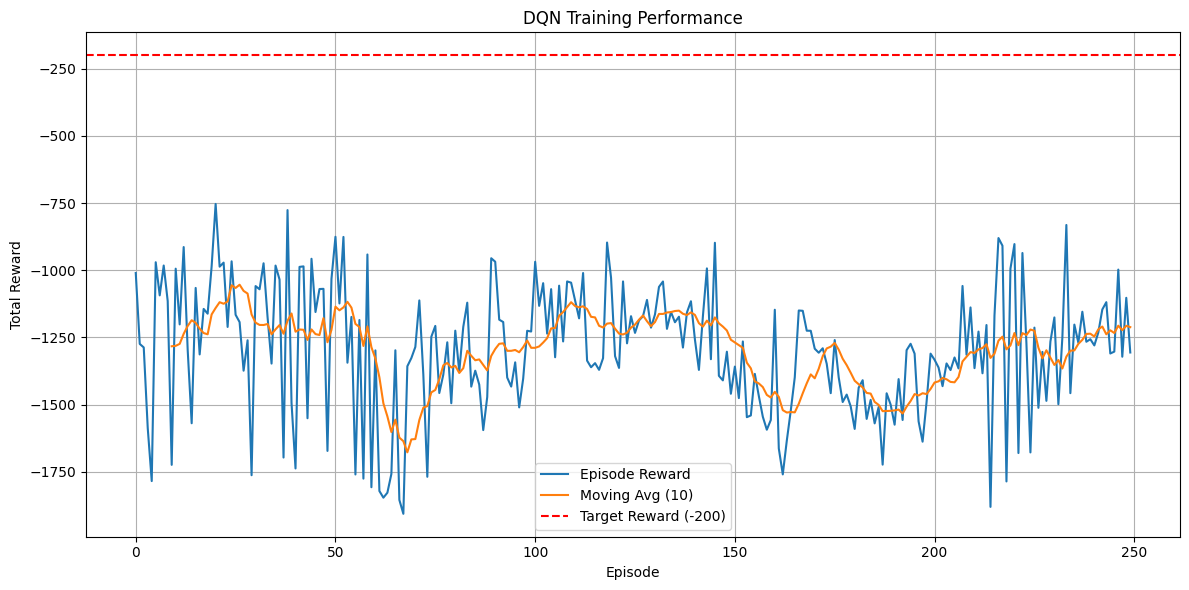

In [11]:
plot_rewards(reward_history, moving_avg_window=10)
